### What is XGBoost?
XGBoost (eXtreme Gradient Boosting) is an optimized version of Gradient Boosting designed for speed and accuracy. It builds decision trees sequentially and improves computational efficiency and predictive performance.

### Key Features
- Regularization: L1 (Lasso) and L2 (Ridge) help control overfitting.

- Tree Pruning: Stops tree growth early to avoid overfitting.

- Missing Value Handling: Automatically handles missing data.

- Parallel Computing: Utilizes multiple CPU cores for faster training.

- Sparsity-Aware: Efficiently processes sparse data.

- Custom Loss Functions: Supports both built-in and user-defined loss functions.

- Cross-Validation: Built-in support to enhance model reliability.

### Advantages
- High Performance: Faster training and prediction.

- Flexibility: Handles regression, classification, ranking, and more.

- Robustness: Handles missing values and outliers effectively.

- Customizability: Allows hyperparameter tuning.

- Feature Importance: Provides insights into important features.

### Key Parameters
- n_estimators: Number of boosting rounds (trees).

- learning_rate: Shrinks tree contributions (smaller values improve generalization).

- max_depth: Maximum tree depth to control complexity.

- subsample: Fraction of training data used per tree.

- colsample_bytree: Fraction of features used per tree.

- gamma: Minimum loss reduction required for splitting.

- lambda and alpha: Regularization parameters to prevent overfitting.

- objective: Specifies the task (e.g., regression, classification).

- early_stopping_rounds: Stops training if no improvement in validation performance.


In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
processed_data = pd.read_csv('/Users/shruti.kalaskar/Documents/Northwestern/Fall 2024/Data Science 339/Project/processed_dataset.csv')
processed_data.head()

,year,hwtsupp,region,statefip,metro,metarea,pernum,relate,age,sex,...,qinclong,hisp,annhrs,incwageman,hrwage,perconexp,hdwfcoh,industry,occupation,education
0,1990,1052.650024,0,36,2.0,5607.0,1,101,58,1,...,0.0,1,1820,14200.0,7.802198,64.639999,1,10,17,5
1,2009,971.200012,2,5,2.0,NaN,4,1260,28,1,...,0.0,0,2080,17680.0,8.500000,100.063004,0,11,17,5
2,1990,1622.280029,0,36,3.0,5607.0,1,101,37,1,...,0.0,0,2080,28000.0,13.461538,64.639999,1,2,4,5
3,1990,2689.909912,3,6,3.0,7400.0,1,101,34,1,...,0.0,0,2115,27500.0,13.002364,64.639999,1,14,3,3
4,1981,1911.900024,2,51,3.0,8840.0,1,101,38,1,...,NaN,0,2080,17000.0,8.173077,43.977001,1,14,0,5


### Dataset Overview
The dataset contains demographic, economic, and employment-related variables, with the target variable being incwage (wage and salary income). A key variable of interest is sex, which is used to group predictions and evaluate potential biases.

- Target Variable: incwage (Wage and salary income)
- Key Sensitive Variable: sex (1 = Male, 2 = Female)

In [3]:
print(processed_data.columns)

Index(['year', 'hwtsupp', 'region', 'statefip', 'metro', 'metarea', 'pernum',
       'relate', 'age', 'sex', 'race', 'marst', 'nativity', 'educ99',
       'classwkr', 'wkswork1', 'hrswork', 'uhrswork', 'union', 'incwage',
       'inclongj', 'srcearn', 'qinclong', 'hisp', 'annhrs', 'incwageman',
       'hrwage', 'perconexp', 'hdwfcoh', 'industry', 'occupation',
       'education'],
      dtype='object')


### Model Overview
Implemented an XGBoost Regressor to predict incwage using the following parameters:

- n_estimators: 100
- learning_rate: 0.1
- max_depth: 3
- random_state: 42

XGBoost was chosen for its high performance, regularization capabilities, and ability to handle missing values.



### Methodology
1. Data Preparation:

- Dropped the target variable (incwage) from features.

- Retained sex as a feature for grouping predictions.

- Split the dataset into training (80%) and testing (20%) sets.

2. Training the Model:

- Used the training data to fit the XGBoost Regressor.

3. Prediction and Grouping:

- Predicted incwage for the test set.

- Grouped predictions by gender to calculate average salary predictions for males and females.

4. Alternated Predictions:

- Created a copy of the test data and alternated the sex column (1 ↔ 2).

- Predicted incwage using the alternated dataset to evaluate potential biases.

- Calculated alternated average salary predictions for males and females.

In [4]:
# Prepare features and target for processed_data
X_processed = processed_data.drop(columns=['incwage', 'sex'])  # Features
y_processed = processed_data['incwage']  # Target: Wage income
X_processed['sex'] = processed_data['sex']  # Retain 'sex' as a feature for grouping

# Train-test split
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

# Train the XGBoost Regressor
xgb_model_processed = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model_processed.fit(X_train_p, y_train_p)

# Predict on test data
y_pred_processed = xgb_model_processed.predict(X_test_p)

# Add gender back to X_test for grouping predictions
X_test_p['gender'] = X_test_p['sex']  # Ensure 'sex' exists in X_test
X_test_p['predictions'] = y_pred_processed

# Separate predictions for males and females
male_predictions_processed = X_test_p[X_test_p['gender'] == 1]['predictions']
female_predictions_processed = X_test_p[X_test_p['gender'] == 2]['predictions']

# Print aggregated results
average_male_prediction = male_predictions_processed.mean()
average_female_prediction = female_predictions_processed.mean()

# Print results
print(f"Average Prediction for Males: {average_male_prediction:.2f}")
print(f"Average Prediction for Females: {average_female_prediction:.2f}")


Average Prediction for Males: 47450.41
Average Prediction for Females: 31384.09


In [5]:
# Copy the test dataset for alternation
X_test_alternated = X_test_p.copy()

# Alternate the `sex` column
X_test_alternated['sex'] = np.where(X_test_alternated['sex'] == 1, 2, 1)

# Ensure only training features are included in alternated dataset
feature_columns = [col for col in X_train_p.columns]  # Use same features as training
X_test_alternated = X_test_alternated[feature_columns]

# Predict using the alternated dataset
alternated_predictions = xgb_model_processed.predict(X_test_alternated)

# Add alternated predictions back to the original X_test
X_test_p['alternated_predictions'] = alternated_predictions

# Separate predictions for alternated males and females
alternated_male_predictions = X_test_p[X_test_p['sex'] == 2]['alternated_predictions']
alternated_female_predictions = X_test_p[X_test_p['sex'] == 1]['alternated_predictions']

# Calculate averages
alternated_male_avg = alternated_male_predictions.mean()
alternated_female_avg = alternated_female_predictions.mean()

# Print results
print(f"Alternated Average Prediction for Males: {alternated_male_avg:.2f}")
print(f"Alternated Average Prediction for Females: {alternated_female_avg:.2f}")


Alternated Average Prediction for Males: 31384.09
Alternated Average Prediction for Females: 47450.41


In [6]:
# Print results

print(f"Average Salary Prediction for Males: {average_male_prediction.mean():.2f}")
print(f"Average Salary Prediction for Females: {average_female_prediction.mean():.2f}")

print(f"Alternated Average Prediction for Males: {alternated_male_avg:.2f}")
print(f"Alternated Average Prediction for Females: {alternated_female_avg:.2f}")

Average Salary Prediction for Males: 47450.41
Average Salary Prediction for Females: 31384.09
Alternated Average Prediction for Males: 31384.09
Alternated Average Prediction for Females: 47450.41


### Results

Original Predictions:

- Average Prediction for Males: $47,450.41

- Average Prediction for Females: $31,384.09

- This shows a significant gap in predicted income between genders.

Alternated Predictions:

- Alternated Average Prediction for Males: $31,384.09

- Alternated Average Prediction for Females: $47,450.41

When the sex attribute is alternated, the average predictions for males and females are flipped, suggesting that sex has a strong influence on the model's predictions.

In [7]:
# Calculate Statistical Parity Difference
statistical_parity_difference = average_male_prediction - average_female_prediction

# Print SPD
print(f"Statistical Parity Difference (SPD): {statistical_parity_difference:.2f}")


Statistical Parity Difference (SPD): 16066.32


### Bias Analysis
The observed results indicate potential bias in the model:

Statistical Parity Difference (SPD):

- SPD=Average Male Prediction−Average Female Prediction=47,450.41−31,384.09=16,066.32

- This large SPD shows a disparity in predictions based on gender.

Alternated Predictions: The exact reversal of predictions after alternation further suggests that sex is playing a dominant role in the model’s decision-making.

In [8]:
print(f"Feature importance of 'sex': {xgb_model_processed.feature_importances_[X_processed.columns.get_loc('sex')]:.5f}")

Feature importance of 'sex': 0.00000


In [9]:
correlation = X_processed.corrwith(y_processed)  # Correlation of each feature with target
print(correlation.sort_values(ascending=False))

incwageman    1.000000
inclongj      0.992219
annhrs        0.336567
educ99        0.321438
uhrswork      0.302809
year          0.280993
perconexp     0.280575
hrswork       0.243749
wkswork1      0.190907
age           0.122137
metro         0.093047
hdwfcoh       0.091270
hrwage        0.043150
industry      0.023794
hwtsupp       0.020368
metarea       0.019377
classwkr      0.008278
srcearn      -0.008012
union        -0.013089
region       -0.018606
statefip     -0.028524
nativity     -0.050597
relate       -0.066972
pernum       -0.074136
race         -0.078846
hisp         -0.083936
marst        -0.087061
sex          -0.179800
occupation   -0.259113
education    -0.271150
qinclong           NaN
dtype: float64


/Users/shruti.kalaskar/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/shruti.kalaskar/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [10]:
corr_value = X_processed['sex'].corr(y_processed)
print(f"Correlation between 'sex' and 'incwageman': {corr_value:.5f}")

Correlation between 'sex' and 'incwageman': -0.17980


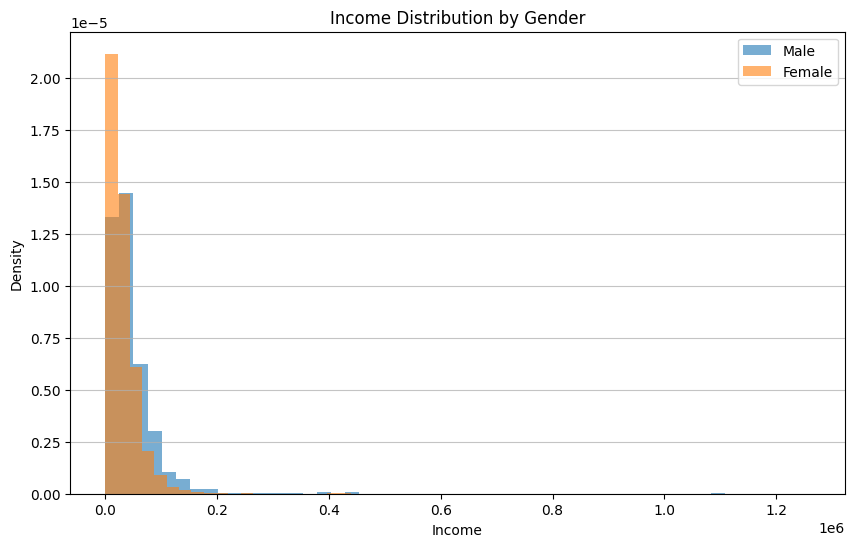

In [11]:
import matplotlib.pyplot as plt

# Ensure `processed_data` is loaded properly. Re-define if necessary.
# processed_data must contain 'sex' and 'incwage' columns.
male_income = processed_data[processed_data['sex'] == 1]['incwage']
female_income = processed_data[processed_data['sex'] == 2]['incwage']

# Plotting Income Distribution by Gender
plt.figure(figsize=(10, 6))
plt.hist(male_income, bins=50, alpha=0.6, label='Male', density=True)
plt.hist(female_income, bins=50, alpha=0.6, label='Female', density=True)
plt.title('Income Distribution by Gender')
plt.xlabel('Income')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid(axis='y', alpha=0.75)
plt.show()


### Observations:

- Both distributions are highly skewed to the right, with most individuals earning lower incomes and fewer individuals earning very high incomes.

- The density of females at the lower-income range is slightly higher than that of males.

- The overlap between the two distributions suggests that both genders share a similar income range, but the male density is slightly higher at the higher-income ranges.

<module 'matplotlib.pyplot' from '/Users/shruti.kalaskar/Library/Python/3.9/lib/python/site-packages/matplotlib/pyplot.py'>

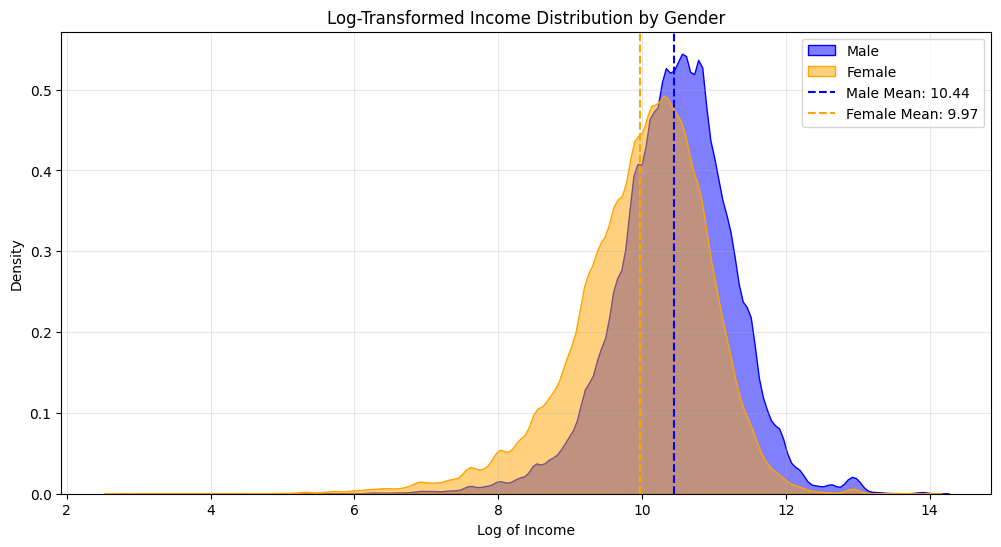

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Apply log transformation to the income data to handle skewness
processed_data['log_income'] = np.log1p(processed_data['incwage'])

# Separate income data by gender
male_income = processed_data[processed_data['sex'] == 1]['log_income']
female_income = processed_data[processed_data['sex'] == 2]['log_income']

# Plot income distribution with KDE
plt.figure(figsize=(12, 6))
sns.kdeplot(male_income, label='Male', fill=True, alpha=0.5, color='blue')
sns.kdeplot(female_income, label='Female', fill=True, alpha=0.5, color='orange')
plt.title('Log-Transformed Income Distribution by Gender')
plt.xlabel('Log of Income')
plt.ylabel('Density')
plt.axvline(male_income.mean(), color='blue', linestyle='--', label=f'Male Mean: {male_income.mean():.2f}')
plt.axvline(female_income.mean(), color='orange', linestyle='--', label=f'Female Mean: {female_income.mean():.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt


### Observations:

- After log transformation, the income distributions become more symmetric and easier to compare.

- Males have a slightly higher mean log income (10.44) compared to females (9.97), indicating a higher average income for males.

- The distributions show significant overlap but highlight that males have a higher density in the upper log-income range.

- The difference in mean log income highlights a gender gap in average earnings.

- Despite the overlap, the male distribution is slightly shifted towards higher incomes, which may suggest systemic factors influencing earnings by gender.
